## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [7]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net().cuda()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2_drop): Dropout(p=0.3)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [76]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [77]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [78]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [79]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [80]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [81]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).cuda()

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [82]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [83]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

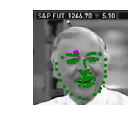

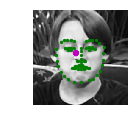

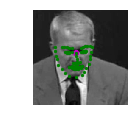

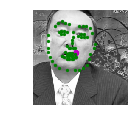

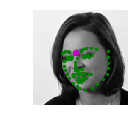

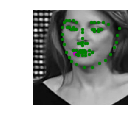

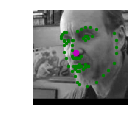

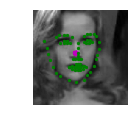

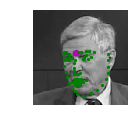

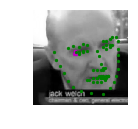

In [87]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        #image = image.numpy()   # convert to numpy array from a Tensor
        image = image.cpu().numpy()   # convert to numpy array from a Tensor ,Use Tensor.cpu() to copy the tensor to host memory first
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        #predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [88]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss().cuda()

#Adam
initial_lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=initial_lr, amsgrad=True, weight_decay=0)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [95]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).cuda()
            images = images.type(torch.FloatTensor).cuda()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 20 == 19:    # print every 20 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [99]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 20, Avg. Loss: 0.0006531950738281012
Epoch: 1, Batch: 40, Avg. Loss: 0.0008856968544423581
Epoch: 1, Batch: 60, Avg. Loss: 0.0005945798438042403
Epoch: 1, Batch: 80, Avg. Loss: 0.0006143659958615899
Epoch: 1, Batch: 100, Avg. Loss: 0.0005480558881536126
Epoch: 1, Batch: 120, Avg. Loss: 0.0005175217324867845
Epoch: 1, Batch: 140, Avg. Loss: 0.00045749867986887694
Epoch: 1, Batch: 160, Avg. Loss: 0.0017223831955343486
Epoch: 1, Batch: 180, Avg. Loss: 0.0006002835026010871
Epoch: 1, Batch: 200, Avg. Loss: 0.0006152642164379358
Epoch: 1, Batch: 220, Avg. Loss: 0.0007746378369629383
Epoch: 1, Batch: 240, Avg. Loss: 0.0006349744349718094
Epoch: 1, Batch: 260, Avg. Loss: 0.0005888701695948839
Epoch: 1, Batch: 280, Avg. Loss: 0.0009513701424002648
Epoch: 1, Batch: 300, Avg. Loss: 0.000574749018996954
Epoch: 1, Batch: 320, Avg. Loss: 0.0005521639026701451
Epoch: 1, Batch: 340, Avg. Loss: 0.0004967033164575696
Epoch: 2, Batch: 20, Avg. Loss: 0.0012201448567211628
Epoch: 2, Batch

Epoch: 9, Batch: 300, Avg. Loss: 0.0005813933927565813
Epoch: 9, Batch: 320, Avg. Loss: 0.0006360228713601828
Epoch: 9, Batch: 340, Avg. Loss: 0.0004650837108492851
Epoch: 10, Batch: 20, Avg. Loss: 0.0004038303606212139
Epoch: 10, Batch: 40, Avg. Loss: 0.00035487285256385805
Epoch: 10, Batch: 60, Avg. Loss: 0.00044743482116609814
Epoch: 10, Batch: 80, Avg. Loss: 0.0004656610796228051
Epoch: 10, Batch: 100, Avg. Loss: 0.00035131764225661754
Epoch: 10, Batch: 120, Avg. Loss: 0.0003345020189881325
Epoch: 10, Batch: 140, Avg. Loss: 0.0003503633001819253
Epoch: 10, Batch: 160, Avg. Loss: 0.0008405475728213787
Epoch: 10, Batch: 180, Avg. Loss: 0.0006933270748704672
Epoch: 10, Batch: 200, Avg. Loss: 0.00044113877601921557
Epoch: 10, Batch: 220, Avg. Loss: 0.0003883990542963147
Epoch: 10, Batch: 240, Avg. Loss: 0.0003825816446915269
Epoch: 10, Batch: 260, Avg. Loss: 0.0004797826604917645
Epoch: 10, Batch: 280, Avg. Loss: 0.0004271682733669877
Epoch: 10, Batch: 300, Avg. Loss: 0.001114525087177

Epoch: 18, Batch: 180, Avg. Loss: 0.0005352669823914766
Epoch: 18, Batch: 200, Avg. Loss: 0.0004563370831310749
Epoch: 18, Batch: 220, Avg. Loss: 0.00041887107491493224
Epoch: 18, Batch: 240, Avg. Loss: 0.00041179991886019704
Epoch: 18, Batch: 260, Avg. Loss: 0.0004119390556588769
Epoch: 18, Batch: 280, Avg. Loss: 0.0005062702037394046
Epoch: 18, Batch: 300, Avg. Loss: 0.00045178535766899583
Epoch: 18, Batch: 320, Avg. Loss: 0.00036225747596472504
Epoch: 18, Batch: 340, Avg. Loss: 0.0005390493581071496
Epoch: 19, Batch: 20, Avg. Loss: 0.00036041620187461377
Epoch: 19, Batch: 40, Avg. Loss: 0.0003686903100460768
Epoch: 19, Batch: 60, Avg. Loss: 0.001578678261488676
Epoch: 19, Batch: 80, Avg. Loss: 0.0009863291578367352
Epoch: 19, Batch: 100, Avg. Loss: 0.0008433197624981403
Epoch: 19, Batch: 120, Avg. Loss: 0.0005746187698096037
Epoch: 19, Batch: 140, Avg. Loss: 0.0007780591137707233
Epoch: 19, Batch: 160, Avg. Loss: 0.0005116055477410555
Epoch: 19, Batch: 180, Avg. Loss: 0.000497436532

Epoch: 27, Batch: 60, Avg. Loss: 0.0004233769057318568
Epoch: 27, Batch: 80, Avg. Loss: 0.0010584538793191314
Epoch: 27, Batch: 100, Avg. Loss: 0.00046848090179264545
Epoch: 27, Batch: 120, Avg. Loss: 0.0003534132544882596
Epoch: 27, Batch: 140, Avg. Loss: 0.0003464250974357128
Epoch: 27, Batch: 160, Avg. Loss: 0.0008620992563664914
Epoch: 27, Batch: 180, Avg. Loss: 0.00046067510824650525
Epoch: 27, Batch: 200, Avg. Loss: 0.0003897318616509438
Epoch: 27, Batch: 220, Avg. Loss: 0.000806906659156084
Epoch: 27, Batch: 240, Avg. Loss: 0.0006051028380170464
Epoch: 27, Batch: 260, Avg. Loss: 0.0006902590589597821
Epoch: 27, Batch: 280, Avg. Loss: 0.0005799681874923408
Epoch: 27, Batch: 300, Avg. Loss: 0.00035547696985304355
Epoch: 27, Batch: 320, Avg. Loss: 0.0003897572485730052
Epoch: 27, Batch: 340, Avg. Loss: 0.00032584415283054113
Epoch: 28, Batch: 20, Avg. Loss: 0.00039734475035220387
Epoch: 28, Batch: 40, Avg. Loss: 0.0008586224494501948
Epoch: 28, Batch: 60, Avg. Loss: 0.0004795566294

Epoch: 35, Batch: 280, Avg. Loss: 0.00033456403110176323
Epoch: 35, Batch: 300, Avg. Loss: 0.00035683608427643774
Epoch: 35, Batch: 320, Avg. Loss: 0.00028410917799919844
Epoch: 35, Batch: 340, Avg. Loss: 0.00032673248182982207
Epoch: 36, Batch: 20, Avg. Loss: 0.00026141234673559665
Epoch: 36, Batch: 40, Avg. Loss: 0.00033273980394005773
Epoch: 36, Batch: 60, Avg. Loss: 0.00048491060361266134
Epoch: 36, Batch: 80, Avg. Loss: 0.0003762181177735329
Epoch: 36, Batch: 100, Avg. Loss: 0.0003326824586838484
Epoch: 36, Batch: 120, Avg. Loss: 0.0003686503227800131
Epoch: 36, Batch: 140, Avg. Loss: 0.0004468537485226989
Epoch: 36, Batch: 160, Avg. Loss: 0.0003796572396531701
Epoch: 36, Batch: 180, Avg. Loss: 0.0007555047292262315
Epoch: 36, Batch: 200, Avg. Loss: 0.0004056783653795719
Epoch: 36, Batch: 220, Avg. Loss: 0.0003320271437987685
Epoch: 36, Batch: 240, Avg. Loss: 0.0004502312112599611
Epoch: 36, Batch: 260, Avg. Loss: 0.0004254381898790598
Epoch: 36, Batch: 280, Avg. Loss: 0.000295130

Epoch: 44, Batch: 160, Avg. Loss: 0.00041081035323441026
Epoch: 44, Batch: 180, Avg. Loss: 0.0005152993090450764
Epoch: 44, Batch: 200, Avg. Loss: 0.0004920347705483437
Epoch: 44, Batch: 220, Avg. Loss: 0.0004927803073078394
Epoch: 44, Batch: 240, Avg. Loss: 0.0004447061782702804
Epoch: 44, Batch: 260, Avg. Loss: 0.0003920834381133318
Epoch: 44, Batch: 280, Avg. Loss: 0.0006413271147757769
Epoch: 44, Batch: 300, Avg. Loss: 0.0009833599058911204
Epoch: 44, Batch: 320, Avg. Loss: 0.000578269180841744
Epoch: 44, Batch: 340, Avg. Loss: 0.0005180536033585668
Epoch: 45, Batch: 20, Avg. Loss: 0.0005025398312136531
Epoch: 45, Batch: 40, Avg. Loss: 0.00045173816196620464
Epoch: 45, Batch: 60, Avg. Loss: 0.0005863271029666066
Epoch: 45, Batch: 80, Avg. Loss: 0.00044590570498257874
Epoch: 45, Batch: 100, Avg. Loss: 0.0003888244079425931
Epoch: 45, Batch: 120, Avg. Loss: 0.0004956214474514126
Epoch: 45, Batch: 140, Avg. Loss: 0.0007770393397659064
Epoch: 45, Batch: 160, Avg. Loss: 0.00047311163507

Epoch: 53, Batch: 40, Avg. Loss: 0.0004526511793956161
Epoch: 53, Batch: 60, Avg. Loss: 0.0003631037017330527
Epoch: 53, Batch: 80, Avg. Loss: 0.000295983774587512
Epoch: 53, Batch: 100, Avg. Loss: 0.00030374956596642734
Epoch: 53, Batch: 120, Avg. Loss: 0.00031706671230494974
Epoch: 53, Batch: 140, Avg. Loss: 0.0003374747112393379
Epoch: 53, Batch: 160, Avg. Loss: 0.0005647424021735787
Epoch: 53, Batch: 180, Avg. Loss: 0.00042658901400864126
Epoch: 53, Batch: 200, Avg. Loss: 0.00030891275824978945
Epoch: 53, Batch: 220, Avg. Loss: 0.0005248392336070538
Epoch: 53, Batch: 240, Avg. Loss: 0.0005852547520771623
Epoch: 53, Batch: 260, Avg. Loss: 0.0007127395672723651
Epoch: 53, Batch: 280, Avg. Loss: 0.0003964460277929902
Epoch: 53, Batch: 300, Avg. Loss: 0.0003065190576016903
Epoch: 53, Batch: 320, Avg. Loss: 0.0004844782575964928
Epoch: 53, Batch: 340, Avg. Loss: 0.000629127730615437
Epoch: 54, Batch: 20, Avg. Loss: 0.0004022008152678609
Epoch: 54, Batch: 40, Avg. Loss: 0.000467601999640

Epoch: 61, Batch: 260, Avg. Loss: 0.0013750097099691628
Epoch: 61, Batch: 280, Avg. Loss: 0.0005288896393030882
Epoch: 61, Batch: 300, Avg. Loss: 0.0003136595906689763
Epoch: 61, Batch: 320, Avg. Loss: 0.00030397098045796154
Epoch: 61, Batch: 340, Avg. Loss: 0.00040373586118221284
Epoch: 62, Batch: 20, Avg. Loss: 0.0004319135118275881
Epoch: 62, Batch: 40, Avg. Loss: 0.0004081077640876174
Epoch: 62, Batch: 60, Avg. Loss: 0.00041728218272328376
Epoch: 62, Batch: 80, Avg. Loss: 0.0003136960407719016
Epoch: 62, Batch: 100, Avg. Loss: 0.00033404952427372334
Epoch: 62, Batch: 120, Avg. Loss: 0.0003373670633882284
Epoch: 62, Batch: 140, Avg. Loss: 0.0002989543993026018
Epoch: 62, Batch: 160, Avg. Loss: 0.0003054909696802497
Epoch: 62, Batch: 180, Avg. Loss: 0.0004911468178033829
Epoch: 62, Batch: 200, Avg. Loss: 0.0003054448333568871
Epoch: 62, Batch: 220, Avg. Loss: 0.00035017217602580786
Epoch: 62, Batch: 240, Avg. Loss: 0.00035056158527731895
Epoch: 62, Batch: 260, Avg. Loss: 0.0004105486

Epoch: 70, Batch: 140, Avg. Loss: 0.0007118406044319272
Epoch: 70, Batch: 160, Avg. Loss: 0.0004447246985509992
Epoch: 70, Batch: 180, Avg. Loss: 0.00035956617072224615
Epoch: 70, Batch: 200, Avg. Loss: 0.00044584382232278584
Epoch: 70, Batch: 220, Avg. Loss: 0.0004042447740212083
Epoch: 70, Batch: 240, Avg. Loss: 0.0003243541847914457
Epoch: 70, Batch: 260, Avg. Loss: 0.0004066149303689599
Epoch: 70, Batch: 280, Avg. Loss: 0.00033980079647153615
Epoch: 70, Batch: 300, Avg. Loss: 0.0010983965033665298
Epoch: 70, Batch: 320, Avg. Loss: 0.0004692882178351283
Epoch: 70, Batch: 340, Avg. Loss: 0.00044244478363543747
Epoch: 71, Batch: 20, Avg. Loss: 0.000361156047321856
Epoch: 71, Batch: 40, Avg. Loss: 0.0003929557693190873
Epoch: 71, Batch: 60, Avg. Loss: 0.0004783344669267535
Epoch: 71, Batch: 80, Avg. Loss: 0.0006339636286720634
Epoch: 71, Batch: 100, Avg. Loss: 0.0004400966316461563
Epoch: 71, Batch: 120, Avg. Loss: 0.00031312953727319836
Epoch: 71, Batch: 140, Avg. Loss: 0.000382574710

Epoch: 79, Batch: 20, Avg. Loss: 0.0003370139952749014
Epoch: 79, Batch: 40, Avg. Loss: 0.0005997032066807151
Epoch: 79, Batch: 60, Avg. Loss: 0.00042224134085699916
Epoch: 79, Batch: 80, Avg. Loss: 0.00038262474304065106
Epoch: 79, Batch: 100, Avg. Loss: 0.0005047555449418724
Epoch: 79, Batch: 120, Avg. Loss: 0.00047644098848104475
Epoch: 79, Batch: 140, Avg. Loss: 0.00041168406419456004
Epoch: 79, Batch: 160, Avg. Loss: 0.00042220997624099255
Epoch: 79, Batch: 180, Avg. Loss: 0.0004392807874828577
Epoch: 79, Batch: 200, Avg. Loss: 0.0006994938803836703
Epoch: 79, Batch: 220, Avg. Loss: 0.0005689242957159877
Epoch: 79, Batch: 240, Avg. Loss: 0.00039347861241549256
Epoch: 79, Batch: 260, Avg. Loss: 0.0005907002277672291
Epoch: 79, Batch: 280, Avg. Loss: 0.0005847637401893735
Epoch: 79, Batch: 300, Avg. Loss: 0.0004417601334862411
Epoch: 79, Batch: 320, Avg. Loss: 0.0006079883333295584
Epoch: 79, Batch: 340, Avg. Loss: 0.0008866940066218376
Epoch: 80, Batch: 20, Avg. Loss: 0.00040089350

Epoch: 87, Batch: 220, Avg. Loss: 0.0003546955529600382
Epoch: 87, Batch: 240, Avg. Loss: 0.00030701785814017055
Epoch: 87, Batch: 260, Avg. Loss: 0.0003263658192008734
Epoch: 87, Batch: 280, Avg. Loss: 0.00032252454292029144
Epoch: 87, Batch: 300, Avg. Loss: 0.00038260654639452697
Epoch: 87, Batch: 320, Avg. Loss: 0.00032749191997572777
Epoch: 87, Batch: 340, Avg. Loss: 0.00034038952365517616
Epoch: 88, Batch: 20, Avg. Loss: 0.00025910854293033483
Epoch: 88, Batch: 40, Avg. Loss: 0.0002900789398699999
Epoch: 88, Batch: 60, Avg. Loss: 0.00037890571355819703
Epoch: 88, Batch: 80, Avg. Loss: 0.00029901196341961623
Epoch: 88, Batch: 100, Avg. Loss: 0.0004749030275270343
Epoch: 88, Batch: 120, Avg. Loss: 0.000370163531973958
Epoch: 88, Batch: 140, Avg. Loss: 0.0003816632060334086
Epoch: 88, Batch: 160, Avg. Loss: 0.00028843428520485757
Epoch: 88, Batch: 180, Avg. Loss: 0.0003794116103090346
Epoch: 88, Batch: 200, Avg. Loss: 0.0004421598166227341
Epoch: 88, Batch: 220, Avg. Loss: 0.00028466

Epoch: 96, Batch: 80, Avg. Loss: 0.00024453453812748195
Epoch: 96, Batch: 100, Avg. Loss: 0.00033210482355207203
Epoch: 96, Batch: 120, Avg. Loss: 0.000289552906062454
Epoch: 96, Batch: 140, Avg. Loss: 0.00030211562756448984
Epoch: 96, Batch: 160, Avg. Loss: 0.00027576471772044895
Epoch: 96, Batch: 180, Avg. Loss: 0.0002357371640391648
Epoch: 96, Batch: 200, Avg. Loss: 0.00044649158651009204
Epoch: 96, Batch: 220, Avg. Loss: 0.00034002738026902077
Epoch: 96, Batch: 240, Avg. Loss: 0.00029792213067412375
Epoch: 96, Batch: 260, Avg. Loss: 0.00022319347551092504
Epoch: 96, Batch: 280, Avg. Loss: 0.00027123020868748425
Epoch: 96, Batch: 300, Avg. Loss: 0.0002743899980559945
Epoch: 96, Batch: 320, Avg. Loss: 0.0002479570750147104
Epoch: 96, Batch: 340, Avg. Loss: 0.0003324762359261513
Epoch: 97, Batch: 20, Avg. Loss: 0.0002416120795533061
Epoch: 97, Batch: 40, Avg. Loss: 0.0002992060612887144
Epoch: 97, Batch: 60, Avg. Loss: 0.0002556768297217786
Epoch: 97, Batch: 80, Avg. Loss: 0.000269677

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [102]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


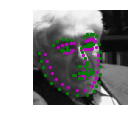

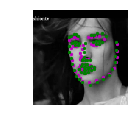

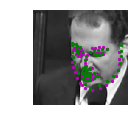

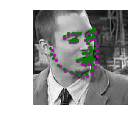

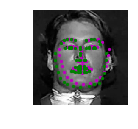

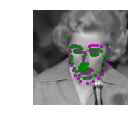

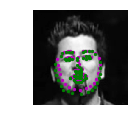

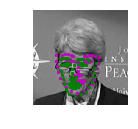

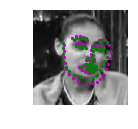

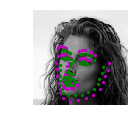

In [103]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [104]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

In [176]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

#w = weights1.numpy()
w = weights1.cpu().numpy()

print(w[0][0])
print(w[0][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


[[ 0.03995543 -0.28820354 -0.10644367  0.03028401 -0.2749883 ]
 [-0.25631133 -0.16906469 -0.06648382  0.02442332 -0.269836  ]
 [ 0.0607366   0.08719745 -0.26222503 -0.19975145  0.03413019]
 [-0.20629323 -0.21286297 -0.24082631 -0.2345193  -0.14452021]
 [-0.15147221 -0.110337    0.02405043  0.00223438 -0.22976473]]
(5, 5)


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

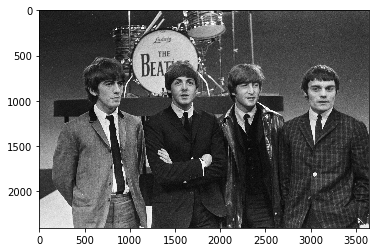

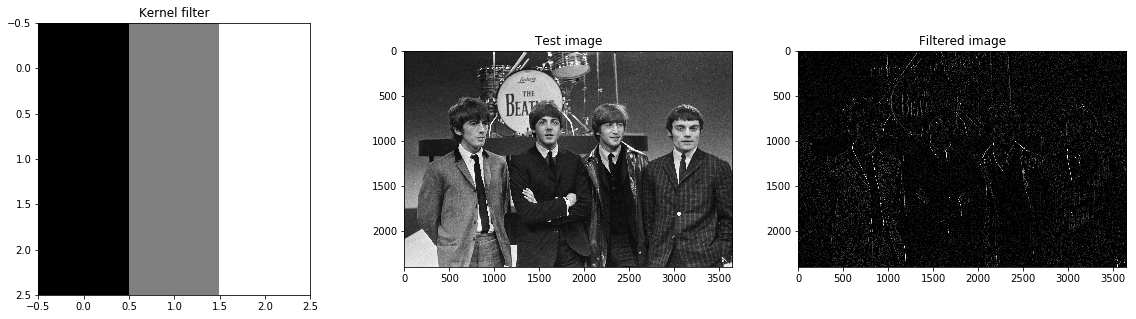

In [150]:
##TODO: load in and display any image from the transformed test dataset
import cv2
image = cv2.imread('images/the_beatles.jpg')
#image = cv2.imread('images/the_beatles.jpg')/255.0
plt.imshow(image, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

kernel = np.array([
    [-1,  0,  1],
    [-1,  0,  1],
    [-1,  0,  1],
])

filtered_image = cv2.filter2D(image, -1, kernel)

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

ax1.imshow(kernel, cmap='gray')
ax2.imshow(image, cmap='gray')
ax3.imshow(filtered_image)

ax1.set_title('Kernel filter')
ax2.set_title('Test image')
ax3.set_title('Filtered image')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

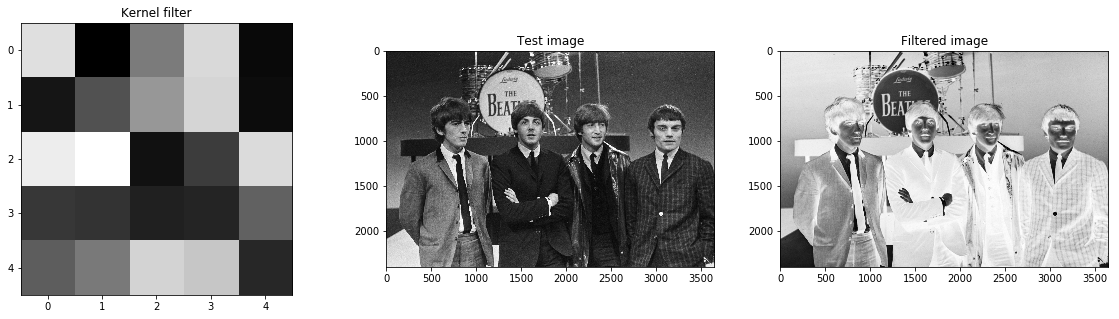

In [181]:
image = cv2.imread('images/the_beatles.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.

filter_kernel = w[0][0]

filtered_image = cv2.filter2D(image, -1, filter_kernel)

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

ax1.imshow(filter_kernel, cmap='gray')
ax2.imshow(image, cmap='gray')
ax3.imshow(filtered_image, cmap='gray')

ax1.set_title('Kernel filter')
ax2.set_title('Test image')
ax3.set_title('Filtered image')

plt.show()

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!